In [3]:
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime,timedelta,date
import sys



import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange, num2date, date2num)
import matplotlib.patches as mpatches
import matplotlib.units as munits
from matplotlib.dates import num2date, date2num

import seaborn as sns


import html


from api_keys import token_esios #importo mi token de esios, añadan su propia clave en su versión

In [4]:
token_esios

'tu_token_de_api_aqui'

# Funciones para bajar los datos

In [8]:
def catalogo_esios(token):
    """
    Descarga todos los identificadores y su descripcion de esios
    
    Parameters
    ----------
    token : str
        El token de esios necesario para realizar las llamadas al API
        
    Returns
    -------
    DataFrame
        Dataframe de pandas con el catalogo de los id de la API
    
    """
    
    
    headers = {'Accept':'application/json; application/vnd.esios-api-v2+json',
           'Content-Type':'application/json',
           'Host':'api.esios.ree.es',
           'Cookie' : '',
           'Authorization':'Token token={}'.format(token),
           'Cache-Control': 'no-cache',
           'Pragma': 'no-cache'
          }
    end_point = 'https://api.esios.ree.es/indicators'
    response = requests.get(end_point, headers=headers).json()
    
    #del resultado en json bruto se convierte en pandas, y se eliminan los tags del campo description

    return (pd
            .json_normalize(data=response['indicators'], errors='ignore')
            .assign(description = lambda df_: df_.apply(lambda df__: html.unescape(df__['description']
                                                            .replace('<p>','')
                                                            .replace('</p>','')
                                                            .replace('<b>','')
                                                            .replace('</b>','')), 
                                                  axis=1)
                   )
           )

In [9]:
def download_esios(token,indicadores,fecha_inicio,fecha_fin,time_trunc='day'):
    """
    Descarga datos esios desde un determinado identidficador y entre dos fechas
    
    Parameters
    ----------
    token : str
        El token de esios necesario para realizar las llamadas al API
    
    indicadores : list
        Lista con los strings de los indicadores de los que queremos bajar datos
        
    fecha_inicio : str
        Fecha con formato %Y-%M-%d, que indica la fecha desde la que se quiere bajar los datos.
        Ejemplo 2022-10-30, 30 Octubre de 2022.
    
    fecha_fin : str
        Fecha con formato %Y-%M-%d, que indica la fecha hasta la que se quiere bajar los datos.
        Ejemplo 2022-10-30, 30 Octubre de 2022.
        
    time_trunc : str, optional
        Campo adicional que nos permite elegir la granularidad de los datos que queremos bajar.
        
    Returns
    -------
    DataFrame
        Dataframe de pandas con los datos solicitados
    
    """
    
    # preparamos la cabecera a insertar en la llamada. Vease la necesidad de disponer el token de esios
    
    headers = {'Accept':'application/json; application/vnd.esios-api-v2+json',
           'Content-Type':'application/json',
           'Host':'api.esios.ree.es',
           'Cookie' : '',
           'Authorization':'Token token={}'.format(token),
           'Cache-Control': 'no-cache',
           'Pragma': 'no-cache'
          }
    
    # preparamos la url básica a la que se le añadiran los campos necesarios 
    
    end_point = 'https://api.esios.ree.es/indicators'
    
    # El procedimiento es sencillo: 
    # a) por cada uno de los indicadores configuraremos la url, según las indicaciones de la documentación.
    # b) Hacemos la llamada y recogemos los datos en formato json.
    # c) Añadimos la información a una lista
    
    lista=[]

    for indicador in indicadores:
        url = f'{end_point}/{indicador}?start_date={fecha_inicio}T00:00&\
        end_date={fecha_fin}T23:59&time_trunc={time_trunc}'
        print (url)
        response = requests.get(url, headers=headers).json()
        lista.append(pd.json_normalize(data=response['indicator'], record_path=['values'], meta=['name','short_name'], errors='ignore'))

    # Devolvemos como salida de la función un df fruto de la concatenación de los elemenos de la lista
    # Este procedimiento, con una sola concatenación al final, es mucho más eficiente que hacer múltiples 
    # concatenaciones.
    
    return pd.concat(lista, ignore_index=True )

In [10]:
def download_ree(indicador,fecha_inicio,fecha_fin,time_trunc='day'):
    """
    Descarga datos desde apidatos.ree.es entre dos fechas determinadas 
    
    Parameters
    ----------
    
    indicador : str
        Texto con el indicador del end point del que queremo bajar la información
        
    fecha_inicio : str
        Fecha con formato %Y-%M-%d, que indica la fecha desde la que se quiere bajar los datos.
        Ejemplo 2022-10-30, 30 Octubre de 2022.
    
    fecha_fin : str
        Fecha con formato %Y-%M-%d, que indica la fecha hasta la que se quiere bajar los datos.
        Ejemplo 2022-10-30, 30 Octubre de 2022.
        
    time_trunc : str, optional
        Campo adicional que nos permite elegir la granularidad de los datos que queremos bajar.
        Hour, Day, Month...dependiendo del end point se aplicará o no esta orden
        
    Returns
    -------
    DataFrame
        Dataframe de pandas con los datos solicitados
    
    """
    
    
    headers = {'Accept': 'application/json',
               'Content-Type': 'applic<ation/json',
               'Host': 'apidatos.ree.es'}
    
    end_point = 'https://apidatos.ree.es/es/datos/'
    
    lista=[]
    url = f'{end_point}{indicador}?start_date={fecha_inicio}T00:00&end_date={fecha_fin}T23:59&\
    time_trunc={time_trunc}'
    print (url)
    
    response = requests.get(url, headers=headers).json()
    
    return pd.json_normalize(data=response['included'], 
                                   record_path=['attributes','values'], 
                                   meta=['type',['attributes','type' ]], 
                                   errors='ignore')

In [11]:
def download_gas(year):
    """
    Descarga datos de precio de gas desde MIBGAS para GDAES
    
    Parameters
    ----------
    year : str
        Indicamos el año del que nos queremos bajar los datos de precio de gas PVB
        
    Returns
    -------
    DataFrame
        Dataframe de pandas con los datos solicitados, columnas Fecha , Producto y Precio
    
    """
    
    path = f'https://www.mibgas.es/en/file-access/MIBGAS_Data_{year}.xlsx?path=AGNO_{year}/XLS'
    return (pd.read_excel(path,sheet_name='Trading Data PVB&VTP',usecols=['Trading day','Product','Daily Reference Price\n[EUR/MWh]']).
       query("Product=='GDAES_D+1'").
       rename(columns={'Trading day':'fecha','Product':'Producto','Daily Reference Price\n[EUR/MWh]':'precio'}).
       sort_values('fecha',ascending=True).
       reset_index(drop=True)
      )

In [12]:
def download_gas_rd(year):
    """
    Descarga datos de precio de gas desde MIBGAS para compensación segñun RD10/2022
    
    Parameters
    ----------
    YEAR : str
        Indicamos el año del que nos queremos bajar los datos de precio de gas de RD10/22
        
    Returns
    -------
    DataFrame
        Dataframe de pandas con los datos solicitados, columnas Fecha , Producto y Precio
    
    """
    
    path = f'https://www.mibgas.es/en/file-access/MIBGAS_Data_{year}.xlsx?path=AGNO_{year}/XLS'
    return (pd.read_excel(path,sheet_name='PGN_RD_10_2022',
                          usecols=['Date','PGN Price\n[EUR/MWh]']).
       rename(columns={'Date':'fecha','PGN Price\n[EUR/MWh]':'precio'}).
       sort_values('fecha',ascending=True).
       reset_index(drop=True)
      )

      

# Datos desde https://www.ree.es/es/apidatos

En el link del título tenemos la descripción del servicio `REST` para acceder a la API. Siguiendo esas instrucciones montamos la funcion `download_ree` para que de manera fácil podamos bajar la información que disponemos.

Veamos un ejemplo práctico bajando la generación, con sus diferentes tipos:

In [13]:
fin = datetime.today().strftime('%Y-%m-%d')  # string con la fecha de hoy en el formato requerido por funcion
inicio = (datetime.today()-timedelta(days=7)).strftime('%Y-%m-%d')
identificador = 'generacion/estructura-generacion'

In [17]:
raw = download_ree(identificador,inicio,fin)
raw

https://apidatos.ree.es/es/datos/generacion/estructura-generacion?start_date=2023-11-03T00:00&end_date=2023-11-10T23:59&    time_trunc=day


,value,percentage,datetime,type,attributes.type
0,99821.900,0.136073,2023-11-03T00:00:00.000+01:00,Hidráulica,Renovable
1,96581.900,0.153132,2023-11-04T00:00:00.000+01:00,Hidráulica,Renovable
2,88871.500,0.139916,2023-11-05T00:00:00.000+01:00,Hidráulica,Renovable
3,111999.100,0.157790,2023-11-06T00:00:00.000+01:00,Hidráulica,Renovable
4,125630.800,0.178193,2023-11-07T00:00:00.000+01:00,Hidráulica,Renovable
...,...,...,...,...,...
131,709797.602,1.000000,2023-11-06T00:00:00.000+01:00,Generación total,Generación total
132,705027.478,1.000000,2023-11-07T00:00:00.000+01:00,Generación total,Generación total
133,692552.066,1.000000,2023-11-08T00:00:00.000+01:00,Generación total,Generación total
134,755114.387,1.000000,2023-11-09T00:00:00.000+01:00,Generación total,Generación total


Veamos un ejemplo de los datos descargados:

Tal como hicimos en el caso anterior vamos a formatear los datos en bruto para sacar la tabla que queremos:

In [ ]:
raw.dtypes

value              float64
percentage         float64
datetime            object
type                object
attributes.type     object
dtype: object

In [ ]:
generacion = (raw
              .assign(fecha=lambda df_: pd
                      .to_datetime(df_['datetime'],utc=True)
                      .dt
                      .tz_convert('Europe/Madrid')
                      .dt
                      .tz_localize(None)
                      )
              .query('type in ["Nuclear","Solar fotovoltaica","Eólica","Hidráulica"]')
              .drop(['attributes.type','datetime','percentage'],axis=1)
              .rename(columns={'value':'valor','type':'tipo','value':'generacion'})[['fecha','tipo','generacion']]
            )

y nos queda tal que así

In [ ]:
generacion

,fecha,tipo,generacion
0,2022-10-30,Hidráulica,31237.000
1,2022-10-31,Hidráulica,32717.000
2,2022-11-01,Hidráulica,29986.500
3,2022-11-02,Hidráulica,35251.500
4,2022-11-03,Hidráulica,34890.100
5,2022-11-04,Hidráulica,31460.800
12,2022-10-30,Nuclear,124157.700
13,2022-10-31,Nuclear,119352.500
14,2022-11-01,Nuclear,119300.100
15,2022-11-02,Nuclear,119241.500


..y los utilizamos para generar un gráfico de barras que nos muestras la evolución de la generación, por cada fuente, en estos días:

Text(0.7, 0.0, '@walyt')

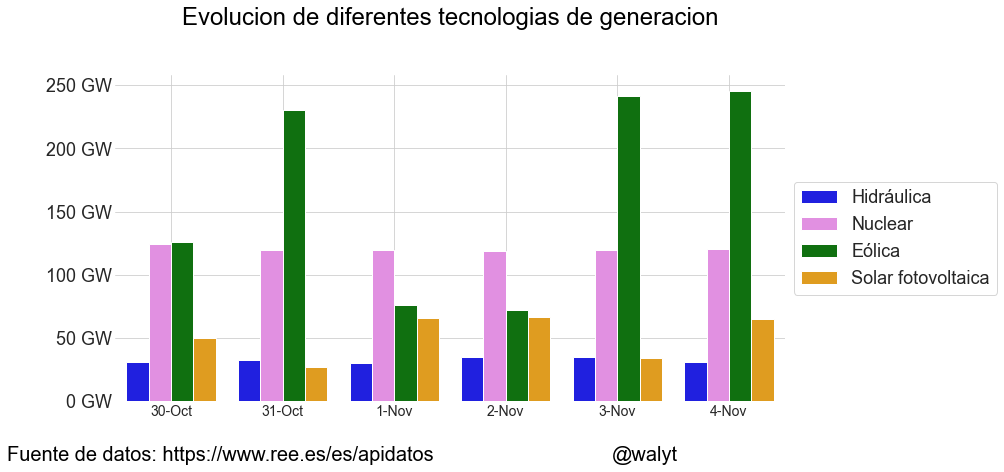

In [ ]:
titulo = f'Evolucion de diferentes tecnologias de generacion'
fuente = 'https://www.ree.es/es/apidatos'
autor='@walyt'

f, ax = plt.subplots(figsize=(12,6))
sns.set_style(style='white')
paleta = ['blue','violet','green','orange']

sns.barplot(
     data=generacion,
     x='fecha', 
     y='generacion',
     ci=None,
     estimator=sum,
     hue='tipo',
     ax=ax,
     palette=paleta
     )

ax.legend(loc='center left',fontsize=18,bbox_to_anchor=(1, 0.5))

ax.xaxis.set_tick_params(labelsize=14,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=18,width=0,rotation=0,pad=-0)

ax.set_ylim(bottom=0)
ax.set_xlabel('')
ax.set_ylabel('')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v/1000:,.0f} GW')) # los datos están en MW

ax.set_xticklabels([i.strftime('%-d-%b') for i in pd.to_datetime(generacion['fecha'].unique())])

sns.despine(left=True, bottom=True)
ax.grid(True)

#Título
ax.set_title('{}'.format(titulo),fontsize=24,color='black',pad=50,y=1.0)

#Indicaciones inferior
f.text(0.0, 0.0, 'Fuente de datos: {}'.format(fuente), horizontalalignment='left',
             verticalalignment='center', fontsize=20,color='black')
f.text(0.7,0.00,'{}'.format(autor),
                 verticalalignment='center',fontsize=20,horizontalalignment='left',color='black')


